# Review of data ingested from TAPoR (draft)

This is document cheks the TAPoR dataset using the python library Pandas.

Reference to ticket: https://gitlab.gwdg.de/sshoc/data-ingestion/-/issues/7


# Preamble

In [79]:
import ast
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

from im_tutorials.data import *
from im_tutorials.utilities import flatten_lists
from im_tutorials.features.text_preprocessing import *
from im_tutorials.features.document_vectors import document_vector
from im_tutorials.features.dim_reduction import WrapTSNE, GaussianMixtureEval
# for db
import sqlalchemy as db
from sqlalchemy import *

In [107]:
engine = create_engine(
      "connectionstring")
connection = engine.connect()
metadata = db.MetaData()

# Import data

## Query the DB to get TAPoR data

The TAPoR dataset used in this document is the sql dump published by Education and Research Archive (ERA) University of Alberta: 

https://era.library.ualberta.ca/items/f2da0666-f523-44d4-a83c-fa06351a1e94 

(creation date: 2020-01-01).
The table *tool* contains 1504 records, each one describing a tool. 
Records have been filtered according the value of the field *tool.is_approved*, there are 1363 *approved* records.
In this document this dataset will be called the **TAPoR dataset**.

*Note that the TAPoR dataset reviewed here is not the same that has been used for the MP ingestion, this document will be update when we'll have it*


In [108]:
df_db_tools=pd.read_sql_query('SELECT * FROM TaPOR.tools where is_approved=1 order by last_updated', connection)
df_db_tools.index

RangeIndex(start=0, stop=1363, step=1)

### An example of TAPoR item
Let's take a look at a random TAPoR dataset entry.
(The database schema of the TAPoR dataset is described here: https://era.library.ualberta.ca/items/f2da0666-f523-44d4-a83c-fa06351a1e94/download/8057eae2-3fae-4afa-bc8e-6dcc2a257b6f.)

In [116]:
#df_db_tools.dtypes
df_db_tools.iloc[500]

id                                                                 254
user_id                                                            NaN
name                                                         TextQuest
detail               <p>TextQuest is a text analysis program availa...
url                  http://www.textquest.de/pages/en/general-infor...
is_approved                                                          1
creators_name                                Social Science Consulting
creators_email                                       info@textquest.de
creators_url                                  http://www.textquest.de/
image_url                                       images/tools/0/254.png
star_average                                                         0
is_hidden                                                            0
last_updated                                                2013-05-13
documentation_url    http://www.textquest.de/pages/en/analysis-of-t...
code  

The following table shows 5 records of the TAPoR dataset.

In [111]:
df_db_tools.sort_values('name').head(5)

,id,user_id,name,detail,url,is_approved,creators_name,creators_email,creators_url,image_url,...,is_hidden,last_updated,documentation_url,code,repository,language,nature,created_at,updated_at,recipes
906,937,1.0,140kit,<p>140kit provides a management layer for twee...,https://github.com/WebEcologyProject/140kit,1,"Ian Pearce, Devin Gaffney",None,None,images/tools/1/937.png,...,0,2018-10-05,None,None,None,NaN,0,2015-05-24 00:00:00,2018-10-05 04:43:34,
334,1229,1.0,3DVIA Virtools,<p>A software tool for the creation of 3D inte...,None,1,Dassault Systemes,None,None,None,...,0,None,None,None,None,NaN,0,2014-12-29 00:00:00,2014-12-29 00:00:00,
688,783,1.0,4th Dimension,4th Dimension is a graphic environment for dev...,http://www.4d.com/products/4d2004/4dstandarded...,1,4D,None,http://www.4d.com/,images/tools/1/783.png,...,0,2018-09-18,None,None,None,NaN,0,2015-05-24 00:00:00,2018-09-18 20:39:31,
1156,648,937.0,80legs,80legs is a web crawling service. You need to ...,http://80legs.com/,1,80legs,,,images/tools/1/648.png,...,0,2018-10-30,None,None,,NaN,0,2017-10-15 23:04:46,2018-10-30 16:03:45,
770,1454,1.0,960 Grid System,<p>960 Grid System is a CSS template that come...,https://960.gs/,1,Nathan Smith,None,http://sonspring.com/,images/tools/2/1454.png,...,0,2018-09-27,None,None,https://github.com/nathansmith/960-Grid-System,NaN,0,2014-12-29 00:00:00,2018-09-27 22:29:43,


### Check for duplicates in TAPoR dataset
Considering the values for 'name' and 'url', it appears that in the TAPoR dataset there are 4 duplicated descriptions

In [117]:
duplicateRowsDF0 = df_db_tools[df_db_tools.duplicated(['name', 'url'])].sort_values('name')
#print("The (possibly) duplicated items in TAPoR dataset:")
duplicateRowsDF0.head(15)

,id,user_id,name,detail,url,is_approved,creators_name,creators_email,creators_url,image_url,...,is_hidden,last_updated,documentation_url,code,repository,language,nature,created_at,updated_at,recipes
1358,148,NaN,AntConc,AntConc is free concordance software. It is mu...,http://www.laurenceanthony.net/software/antconc/,1,Laurence Anthony,anthony@waseda.jp,http://www.antlab.sci.waseda.ac.jp/index.html,images/tools/0/148.png,...,0,2019-08-19,http://www.laurenceanthony.net/software/antcon...,None,,NaN,0,2012-07-30 18:25:44,2019-08-19 00:37:45,
1362,1565,1201.0,SentiStrength,SentiStrength is a sentiment analysis (opinion...,http://sentistrength.wlv.ac.uk/,1,Mike Thelwall,m.thelwall@wlv.ac.uk,http://sentistrength.wlv.ac.uk,images/tools/3/1565.png,...,0,2019-09-27,None,None,,NaN,0,2019-09-20 05:03:47,2019-09-27 10:03:35,
652,580,937.0,Voyant 2.0: Knots,Voyant Knots is a visualization where a line i...,http://voyant-tools.org/?view=knots,1,Stéfan Sinclair and Geoffrey Rockwell,stefan.sinclair@mcgill.ca,http://stefansinclair.name/,images/tools/1/580.png,...,1,2016-04-29,None,None,,NaN,0,2016-04-29 16:08:28,2017-10-31 14:26:36,
653,581,937.0,Voyant 2.0: Knots,Voyant Knots is a visualization where a line i...,http://voyant-tools.org/?view=knots,1,Stéfan Sinclair and Geoffrey Rockwell,stefan.sinclair@mcgill.ca,http://stefansinclair.name/,images/tools/1/581.png,...,0,2016-04-29,None,None,,NaN,0,2016-04-29 16:11:55,2017-10-31 14:26:36,


## Get the ingested  TAPoR data in the Market Place (using the API)

The SSHOC Market Place API entry: 

 https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools

has been used to extract the TAPoR descriptions imported in the SSHOC Market Place. In the rest of the document this dataset will be called: **MP dataset**

In [7]:
#x = ('2','3','4','5')
x = pd.Series(range(2,69))
url = 'https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools?page=1&perpage=20'
df_tool_all = pd.read_json(url, orient='columns')
for var in x:
    url = "https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools?page="+str(var)+"&perpage=20"
    df_tool_par=pd.read_json(url, orient='columns')
    df_tool_all=df_tool_all.append(df_tool_par, ignore_index=True)
   # print("url: "+ url + ":",var)
df_tool_all.index

RangeIndex(start=0, stop=1353, step=1)

There are 1353 tool descriptions in MP dataset. The following table shows 10 records of the MP dataset.

Let's take a look at row 500 of the MP dataset

In [113]:
#descriptions are in JSON,  create a dataframe
df_tool_flat = pd.json_normalize(df_tool_all['tools'])
df_tool_flat.iloc[500]
#df_tool_flat.sort_values('label').head(10)

id                                                                      1388
category                                                                tool
label                                                                 InTEXT
version                                                                 None
description                InTEXT is a legacy, commercial suite of progra...
licenses                                                                  []
contributors               [{'actor': {'id': 956, 'name': 'InTEXT Systems...
properties                 [{'id': 14091, 'type': {'code': 'tadirah-metho...
accessibleAt                                              http://intext.com/
sourceItemId                                                             247
relatedItems                                                              []
informationContributors    [{'id': 4, 'username': 'System importer', 'dis...
lastInfoUpdate                                      2020-06-28T18:25:58+0000

In the MP dataset there are 1353 tool descriptions.

In [9]:
df_tool_flat.index

RangeIndex(start=0, stop=1353, step=1)

#### Considering the values for 'label' and 'accessibleAT', it appears that in the MP dataset there are 9 duplicated descriptions

In [94]:
test_p_d=df_tool_flat[df_tool_flat.duplicated(['label', 'accessibleAt'])].sort_values('label')
test_p_d

,id,category,label,version,description,licenses,contributors,properties,accessibleAt,sourceItemId,...,status,comments,olderVersions,newerVersions,repository,source.id,source.label,source.url,source.urlTemplate,source
326,335,tool,EVI-LINHD,None,EVI-LINHD is a free and open-source cloud plat...,[],"[{'actor': {'id': 275, 'name': 'Elena González...","[{'id': 2702, 'type': {'code': 'thumbnail', 'l...",http://www.evilinhd.com/,594,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
532,776,tool,JSAN,None,The Integrated JStylo and Anonymouth Package. ...,[],"[{'actor': {'id': 493, 'name': '18th Connect',...","[{'id': 7310, 'type': {'code': 'thumbnail', 'l...",https://github.com/psal/jstylo,1559,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
533,451,tool,JSAN,None,The Integrated JStylo and Anonymouth Package. ...,[],"[{'actor': {'id': 493, 'name': '18th Connect',...","[{'id': 4037, 'type': {'code': 'keyword', 'lab...",https://github.com/psal/jstylo,1557,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
697,1186,tool,NodeXL,None,"NodeXL is a free, open source tool for generat...",[],"[{'actor': {'id': 832, 'name': 'M. Smith, N. M...","[{'id': 11766, 'type': {'code': 'license-type'...",http://nodexl.codeplex.com/,482,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
854,560,tool,Python Tools for Text-Analysis,None,"This is a set of simple, free tools for analyz...",[],"[{'actor': {'id': 424, 'name': 'David L. Hoove...","[{'id': 5060, 'type': {'code': 'thumbnail', 'l...",https://wp.nyu.edu/exceltextanalysis/python_to...,1507,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
947,1136,tool,SentiStrength,None,SentiStrength is a tool for sentiment analysis...,[],"[{'actor': {'id': 799, 'name': 'Thelwall, M., ...","[{'id': 11290, 'type': {'code': 'keyword', 'la...",http://sentistrength.wlv.ac.uk/,453,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
948,378,tool,SentiStrength,None,It is a sentiment analysis program. Automatic ...,[],"[{'actor': {'id': 493, 'name': '18th Connect',...","[{'id': 3210, 'type': {'code': 'thumbnail', 'l...",http://sentistrength.wlv.ac.uk/,1564,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
1187,607,tool,UCINET,None,UCINET is a social media analysis set for soft...,[],"[{'actor': {'id': 459, 'name': 'Borgatti, S.P....","[{'id': 5501, 'type': {'code': 'tadirah-method...",https://sites.google.com/site/ucinetsoftware/home,576,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN
476,165,tool,igraph,None,igraph is an open source collection of network...,[],"[{'actor': {'id': 147, 'name': 'Gábor Csárdi, ...","[{'id': 771, 'type': {'code': 'tadirah-methods...",http://igraph.org/,623,...,ingested,[],[],[],None,1.0,TAPoR,http://tapor.ca,http://tapor.ca/tools/{source-item-id},NaN


In [11]:
#df_tool_flat.dtypes 

In [12]:
df_tool_flat['accessibleAt'].replace(np.nan, "", inplace=True)
df_tool_flat['accessibleAt'].replace(r'^\s*$', "", regex=True)
#df_tool_flat['accessibleAt'].isnull()

0             https://github.com/WebEcologyProject/140kit
1                                                        
2       http://www.4d.com/products/4d2004/4dstandarded...
3                                      http://80legs.com/
4                                         https://960.gs/
                              ...                        
1348                                                     
1349                              https://www.zotero.org/
1350                                  http://zotfile.com/
1351              https://wordpress.org/plugins/zotpress/
1352    http://www.zubrag.com/tools/html-tags-stripper...
Name: accessibleAt, Length: 1353, dtype: object

In [13]:
#dataframe for MP properties
df_prop_data = pd.json_normalize(data=df_tool_all['tools'], record_path='properties', meta=['label'])
#df_prop_data.head(10)

In [14]:
#dataframe for MP contributors
df_contr_data = pd.json_normalize(data=df_tool_all['tools'], record_path='contributors', meta=['label'])
#df_contr_data.head(10)

In [15]:
df_mpdatasets=df_tool_flat.join(df_contr_data.set_index('label'), on='label')
#df_mpdatasets.head()

### Comparing TAPoR dataset and MP datasets to find import issues

In [16]:
#create a dataframe with a subset of columns for the TAPoR dataset
df_tapor_worksub=df_db_tools.sort_values('name')[['name', 'url']].drop_duplicates()
df_tapor_worksub['url'].replace(np.nan, "", inplace=True)
df_tapor_worksub['url'].replace(r"\s+", np.nan, regex=True)
#df_tapor_worksub['url'].isnull()
#df_tapor_worksub.tail(30)

906           https://github.com/WebEcologyProject/140kit
334                                                      
688     http://www.4d.com/products/4d2004/4dstandarded...
1156                                   http://80legs.com/
770                                       https://960.gs/
                              ...                        
816                  http://www.jasondavies.com/wordtree/
520                    http://code.google.com/p/word2vec/
815             https://code.google.com/p/wordsimilarity/
702     http://www.tei-c.org/Vault/MembersMeetings/200...
45                                                       
Name: url, Length: 1359, dtype: object

In [54]:
#create a dataframe with a subset of columns for the MP dataset and change column names to have homogenous formats
df_mp_taporsub= df_tool_flat[df_tool_flat['source.label'] == 'TAPoR']
df_mp_worksub=df_mp_taporsub.sort_values('label')[['label','accessibleAt']].drop_duplicates()
df_mp_worksub=df_mp_worksub.rename(columns={"label": "name", 'accessibleAt':'url'})
#df_mp_worksub['url'].isnull()

In [55]:
# define a function that compares dataframes
def dataframe_difference(df1, df2, which):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    diff_df.to_csv('data/diff.csv')
    return diff_df

#### Considering  values for 'name' and 'url', there are 1260 tool descriptions in MP dataset that are identical to descriptions in TAPoR dataset

In [63]:
df_both=dataframe_difference(df_mp_worksub, df_tapor_worksub, 'both')
df_both.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342],
           dtype='int64', length=1260)

In [76]:
df_both.head()

,name,url,_merge
0,140kit,https://github.com/WebEcologyProject/140kit,both
1,3DVIA Virtools,,both
2,4th Dimension,http://www.4d.com/products/4d2004/4dstandarded...,both
3,80legs,http://80legs.com/,both
4,960 Grid System,https://960.gs/,both


#### Considering values for 'name' and 'url',  there are 83 tool descriptions in  MP dataset but not in TAPoR dataset

In [77]:
#tools in TAPoR but not in MP datset
df_lo=dataframe_difference(df_mp_worksub.sort_values('name'), df_tapor_worksub.sort_values('name'), 'left_only')
# see 20 records in MP dataset but not in TAPoR
df_lo.head(20)

,name,url,_merge
142,CONDOR,http://www.ickn.org/ckntools.html,left_only
144,CQPweb,https://cqpweb.lancs.ac.uk/,left_only
146,CSV Sort,https://bitbucket.org/richardpenman/csvsort,left_only
156,CasualConc,https://sites.google.com/site/casualconc/,left_only
161,Chartle,,left_only
163,Chorus,http://chorusanalytics.co.uk/,left_only
165,Chronos Timeline,http://hyperstudio.mit.edu/software/chronos-ti...,left_only
180,Code Bubbles,http://cs.brown.edu/~spr/codebubbles/,left_only
184,Colaboratory,https://colab.research.google.com/notebooks/we...,left_only
214,ContaWords,http://contawords.iula.upf.edu/,left_only


#### Comparing values for 'name' and 'url', there are 99 tool descriptions in  TAPoR dataset but not in MP dataset

In [70]:
#Tools in MP dataset but not in TAPoR
df_ro=dataframe_difference(df_mp_worksub.sort_values('name'), df_tapor_worksub.sort_values('name'), 'right_only')
df_ro.head(20)

,name,url,_merge
1343,ANNIS,,right_only
1344,Adobe Flash,,right_only
1345,Ainm.ie,,right_only
1346,Alpheios,,right_only
1347,Anastasia,,right_only
1348,ArcExplorer,,right_only
1349,AroniSmartIntelligence™,,right_only
1350,Aruspix,,right_only
1351,BASE,,right_only
1352,Basement Waterproofing: Tips and Instructions,,right_only


## Distribution of items in TAPoR dataset by 'last_updated' value

Check the content of the field 'last_update' for TAPoR dataset descriptions. This value *seems* the date when a description of a tool has been  updated the last time.


In [120]:
df_db_tools['correctdata']=pd.to_datetime(df_db_tools['updated_at'])
df_db_tools['justdata'] = df_db_tools['correctdata'].dt.year
df_reg_tm_sorted=df_db_tools.sort_values('updated_at')
df_reg_tools_sub=df_reg_tm_sorted[['name', 'url', 'updated_at']]
df_reg_tools_sub.head()

,name,url,updated_at
334,3DVIA Virtools,None,2014-12-29
136,Exceed,None,2014-12-29
290,Pattern,None,2014-12-29
286,HathiTrust Digital Library,None,2014-12-29
142,Lextek,None,2014-12-29


Text(0.5, 1.0, 'Number of tools by year their description has been updated')

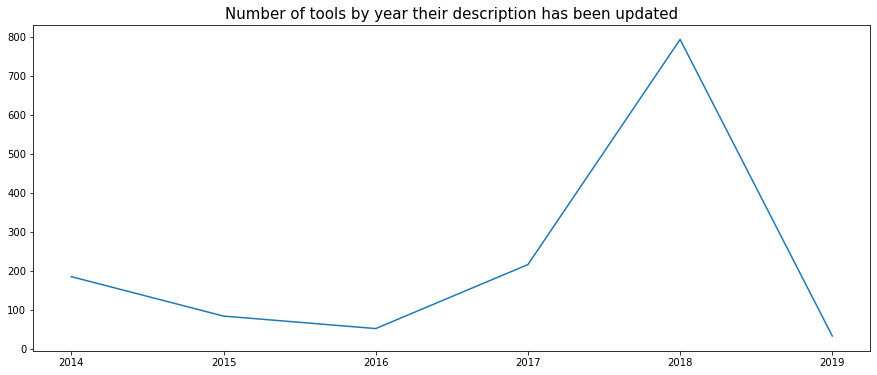

In [121]:
f, ax1 = plt.subplots(nrows=1, figsize=(15,6))
df_reg_tm_sorted.justdata.value_counts().reindex(sorted(df_reg_tm_sorted.justdata.value_counts().index)).plot(ax=ax1)
ax1.set_title('Number of tools by year their description has been updated', fontsize=15)

## Check URL in TAPoR dataset
In TAPoR dataset there are descriptions where the URL of a Tool is not provided

In [24]:
df_reg_tools_sub_emurl=df_reg_tools_sub[df_reg_tools_sub['url'] == '']
#print("number of record with missed URL in TAPoR dataset:")
df_reg_tools_sub_emurl.count()

name            136
url             136
last_updated    136
dtype: int64

In [25]:
df_reg_tools_sub_whurl=df_reg_tools_sub[df_reg_tools_sub['url'] != '']
df_reg_tools_sub_whurl.index

Int64Index([423, 446, 444, 443, 442, 441, 440, 439, 438, 437,
            ...
            413, 414, 415, 416, 417, 418, 419, 420, 421, 422],
           dtype='int64', length=1227)

In [26]:
#df_reg_tools_sub.head()
#for column in df_reg_tools_sub[['name', 'url']]:
#   # Select column contents by column name using [] operator
#   columnSeriesObj = df_reg_tools_sub[column]
#   print('Colunm Name : ', column)
#   print('Column Contents : ', columnSeriesObj.values)
df_urls=df_reg_tools_sub_whurl.url.values
#df_urls

In [27]:
data = {'url':  ['test'],'status': [1]}
df_http_status = pd.DataFrame (data, columns = ['url','status'])
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)


for var in df_urls:
   # print(var)
    if ( var != "" and var!=None and re.match(regex, var)):
        try:
            r =requests.get(var,timeout=8)
            #print("result: "+var+ " ",r.status_code)
            df_http_status = df_http_status.append({'url': var, 'status': int(r.status_code)}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_http_status = df_http_status.append({'url': var, 'status': int(503)}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_http_status = df_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_http_status = df_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_http_status = df_http_status.append({'url': var, 'status': int(500)}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_http_status = df_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
    else:
       # print(var ,0)
        df_http_status = df_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
df_http_status.head()

,url,status
0,test,1.0
1,http://taporware.ualberta.ca/~taporware/htmlTo...,404.0
2,http://taporware.ualberta.ca/~taporware/textTo...,404.0
3,http://taporware.ualberta.ca/~taporware/htmlTo...,404.0
4,http://taporware.ualberta.ca/~taporware/textTo...,404.0


### The HTTP result status values for URL in TAPoR dataset descriptions

The table below shows the HTTP Status code (https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) obtained when 'clicking' on URL of tool descriptions of TAPoR dataset.

There is a significant number of URLs that seems not correct (status 404, 503, 500, 508....)

In [28]:
df_http_status_sub=df_http_status[df_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
df_db_st.head(10)

200.0    652
400.0    442
404.0     83
503.0     25
403.0     11
406.0      7
408.0      3
500.0      2
502.0      1
420.0      1
Name: status, dtype: int64

## TAPoR dataset 'creators' 
There are 164 descriptions in TAPoR dataset that don't have values in *creators_name* field, and there are 924 different creators. 


In [29]:
df_db_tools_na=df_db_tools[df_db_tools['creators_name'] == ''].sort_values('last_updated')
df_db_tools_na.index

Int64Index([649, 686, 697, 701, 706, 719, 733, 736, 746, 765,
            ...
            405, 407, 408, 410, 412, 414, 416, 417, 420, 422],
           dtype='int64', length=164)

In [30]:
#the number of creators
len(df_db_tools['creators_name'].unique())-1

924

In [31]:
df_db_tools.loc[df_db_tools['creators_name']=='','creators_name']='n/a'
df_db_tech_NoCoT = df_db_tools['creators_name'].value_counts()

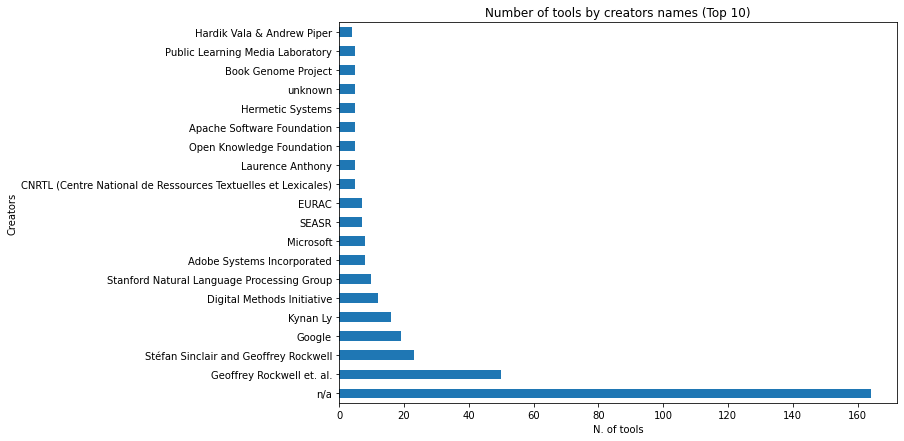

In [32]:
fig, ax = plt.subplots()
df_db_tech_NoCoT.head(20).plot.barh(figsize=(10,7), ax=ax)
ax.set_title('Number of tools by creators names (Top 10)')
ax.set_xlabel('N. of tools')
ax.set_ylabel('Creators');

Number of tool descriptions in TAPoR dataset that don't have the related creator email

In [101]:
df_db_tools_naem=df_db_tools[df_db_tools['creators_email'] == ''].sort_values('last_updated')
#df_db_tools_naem.index
len(df_db_tools_naem)

382

Number of tool description in TAPoR dataset that don't have the related creator URL

In [102]:
df_db_tools_nau=df_db_tools[df_db_tools['creators_url'] == ''].sort_values('last_updated')
len(df_db_tools_nau)

171

# ------ 

In [35]:
df_db_tech=pd.read_sql_query('select t.id, t.name, t.detail, t.creators_name, t.last_updated, at.name as "attributetype", av.name as"attribute", tags.text as "tag" from TaPOR.tools as t, TaPOR.attribute_values as av, TaPOR.tool_attributes as ta, TaPOR.attribute_types as at, TaPOR.tags as tags, TaPOR.tool_tags as tota where t.is_approved=1 and t.id=ta.tool_id and t.id=tota.tool_id and tags.id=tota.tag_id and ta.attribute_value_id=av.id and ta.attribute_type_id=at.id', connection)
#df_db_tech=pd.read_sql_table('tools', connection)

In [36]:
#df_db_tech.head(10)

In [37]:
df_db_tech.index

RangeIndex(start=0, stop=43845, step=1)

In [38]:
df_db_tech.columns

Index(['id', 'name', 'detail', 'creators_name', 'last_updated',
       'attributetype', 'attribute', 'tag'],
      dtype='object')

In [39]:
df_items=df_db_tech[['id', 'name', 'detail', 'creators_name', 'last_updated']].drop_duplicates()
#df_items.head(10)

## Attributes in TAPoR dataset items

The following dataframe shows the list of attribute types defined in TaPOR dataset to charachterize tools

In [103]:
df_db_tools_toa=pd.read_sql_query('SELECT distinct name FROM TaPOR.attribute_types', connection)
df_db_tools_toa.head(20)

,name
0,Type of analysis
1,Type of license
2,Background Processing
3,Web Usable
4,Ease of Use
5,Warning
6,Usage
7,Tool Family
8,Historic Tool (developed before 2005)
9,Compute Canada


### Tools with no attribute in TAPoR dataset

The following dataframe shows the main fields of tool descriptions in TAPoR dataset that do not have attribute values

In [104]:
df_db_tools_noatt=pd.read_sql_query('select distinct tools.id, tools.name, tools.creators_name, tools.url from TaPOR.tools where tools.is_approved=1 and tools.id not in (select distinct TaPOR.tool_attributes.tool_id from TaPOR.tool_attributes)', connection)
df_db_tools_noatt.head(19)

,id,name,creators_name,url
0,579,Voyant 2.0: Knots,Stéfan Sinclair and Geoffrey Rockwell,http://voyant-tools.org/?view=knots
1,591,Warc Extractor,Ryan Chartier & Internet Archive,https://github.com/recrm/ArchiveTools/blob/mas...
2,754,TAGS https://t.co/T007ezdZoA,,None
3,755,Multiple enhancements to DiRT Directory (tools...,,None
4,758,"RT : Today's ""dirt"": DiRT now uses TaDiRAH ter...",,None
5,823,Basement Waterproofing: Tips and Instructions,,None
6,1017,Datapress,MIT CSAIL,None
7,1063,WordVenture,WordNet,None
8,1174,VoiceThread,VoiceThread LLC,None
9,1183,Purdue OWL,"Purdue University Writing Lab, Purdue Universi...",None


## Type of Licenses in TAPoR dataset items

In [42]:
df_db_sub=df_db_tech[['id', 'name', 'detail', 'creators_name', 'last_updated', 'attributetype', 'attribute']]
df_to=df_db_sub[df_db_sub['attributetype'] == 'Type of license'].drop_duplicates()
df_to.index

Int64Index([    8,    40,    44,   108,   170,   306,   330,   344,   362,
              380,
            ...
            43679, 43728, 43730, 43751, 43762, 43779, 43814, 43816, 43821,
            43824],
           dtype='int64', length=1024)

In [43]:
df_db_lic = df_to['attribute'].value_counts()
df_db_lic.head(10)

Free                470
Open Source         256
Closed Source       195
Commercial           79
Creative Commons     22
Shareware             2
Name: attribute, dtype: int64

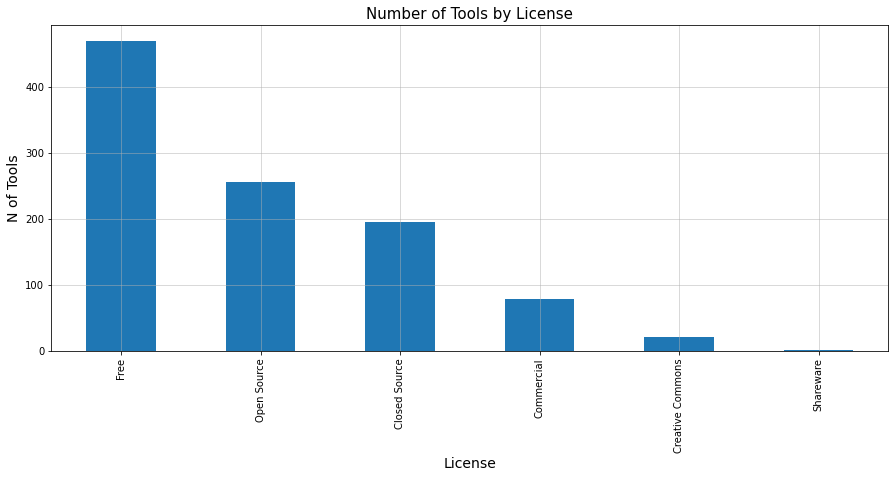

In [44]:
fig, ax = plt.subplots()
df_db_lic.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by License", fontsize=15)
ax.set_xlabel('License', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

In [45]:
#df_db_tech.loc[df_db_tech['country']=='', 'country']='N/A'

## *Type of analysis*  in TAPoR dataset items

A tool description can have more than one value for *Type of analysis* (i.e. a tool can perform one or more type of analysis)

In [119]:
df_to_ta=df_db_sub[df_db_sub['attributetype'] == 'Type of analysis'].drop_duplicates()
df_to_ta.tail(10)

,id,name,detail,creators_name,last_updated,attributetype,attribute
43724,1499,iPhoto,<p>iPhoto is a digital photograph manipulation...,Apple,2018-10-12,Type of analysis,Organizing
43726,1499,iPhoto,<p>iPhoto is a digital photograph manipulation...,Apple,2018-10-12,Type of analysis,Storage
43748,1500,Google 3D Warehouse,<p>A collection of free-to-download 3D models ...,Google,2018-11-06,Type of analysis,Collaboration
43749,1500,Google 3D Warehouse,<p>A collection of free-to-download 3D models ...,Google,2018-11-06,Type of analysis,Dissemination
43750,1500,Google 3D Warehouse,<p>A collection of free-to-download 3D models ...,Google,2018-11-06,Type of analysis,Modeling
43759,1501,SketchUp (Formerly Google SketchUp),<p>Google SketchUp is easy-to-use free 3D mode...,Google,2018-10-26,Type of analysis,Creation
43760,1501,SketchUp (Formerly Google SketchUp),<p>Google SketchUp is easy-to-use free 3D mode...,Google,2018-10-26,Type of analysis,Interpretation
43761,1501,SketchUp (Formerly Google SketchUp),<p>Google SketchUp is easy-to-use free 3D mode...,Google,2018-10-26,Type of analysis,Modeling
43790,1502,GIMP (GNU Image Manipulation Program),"<p>GIMP is image editing software, much like P...",GIMP Team,None,Type of analysis,Creation
43818,1556,Reaper,REAPER is a complete digital audio production ...,Cockos,2019-03-24,Type of analysis,Creation


In [47]:
df_db_a = df_to_ta['attribute'].value_counts()
df_db_a.head(25)

Analysis                       434
Visualization                  236
Content Analysis               185
Search                         139
Natural Language Processing    125
Discovering                    124
Capture                        113
Gathering                       97
Publishing                      92
Dissemination                   91
Enrichment                      90
Annotating                      83
Collaboration                   80
Organizing                      71
Creation                        52
Uncategorized                   49
Storage                         40
Web development                 39
Modeling                        25
Programming                     22
Interpretation                  18
RDF                             12
Name: attribute, dtype: int64

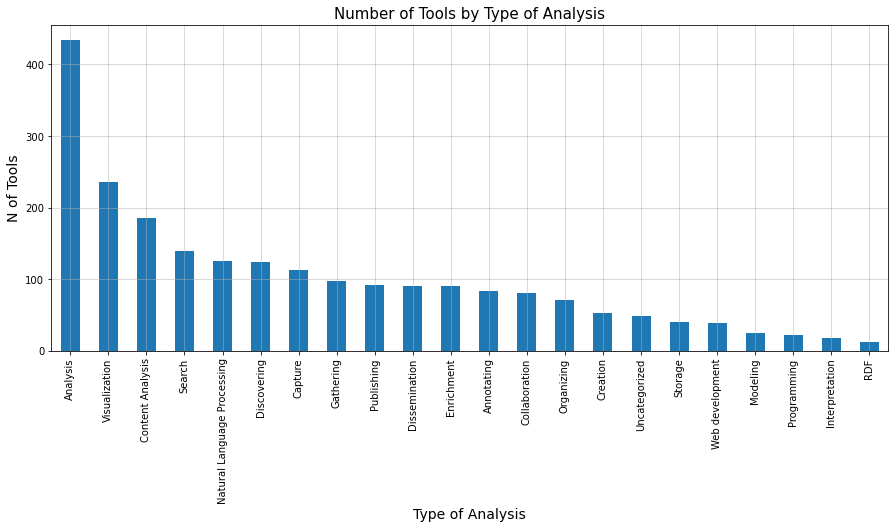

In [48]:
fig, ax = plt.subplots()
df_db_a.plot(kind='bar', figsize=(15,6), x='analysys', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Type of Analysis", fontsize=15)
ax.set_xlabel('Type of Analysis', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## *Tool families* in TAPoR dataset items

In [49]:
df_to_tf=df_db_sub[df_db_sub['attributetype'] == 'Tool Family'].drop_duplicates()
df_to_tf = df_to_tf['attribute'].value_counts()
df_to_tf.head(20)

TAPoRware                     55
Voyant                        18
Digital Methods Initiative    12
Stanford NLP                  11
SEASR                          8
SIMILE Widgets                 6
EURAC                          5
CNRTL                          5
Visualizing Literature         5
Book Genome Project            5
CHNM                           4
Orlando                        3
Laurence Anthony               3
Stanford HCI Group             2
Stanford Vis Group             2
Scholars' Lab                  2
Name: attribute, dtype: int64

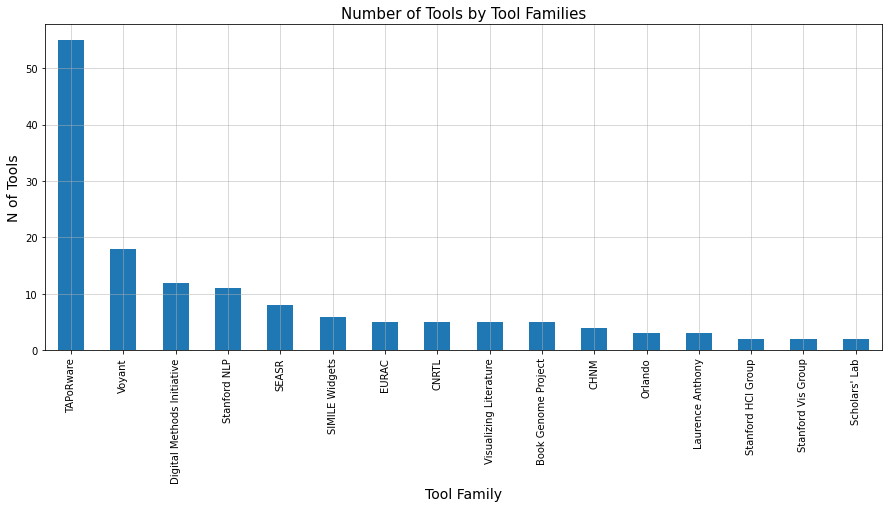

In [50]:
fig, ax = plt.subplots()
df_to_tf.plot(kind='bar', figsize=(15,6), x='analysys', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Tool Families", fontsize=15)
ax.set_xlabel('Tool Family', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## *Web Usable*  in TAPoR items

In [51]:
df_to_bp=df_db_sub[df_db_sub['attributetype'] == 'Web Usable'].drop_duplicates()
df_to_bp.head()

,id,name,detail,creators_name,last_updated,attributetype,attribute
16,1,List Words - HTML (TAPoRware),"<p>This tool lists words in an HTML document, ...",Geoffrey Rockwell et. al.,2011-11-27,Web Usable,Run in Browser
52,4,Wordle,<p>Wordle is an online toy for generating <a h...,Jonathan Feinberg,2018-10-17,Web Usable,Run in Browser
82,5,OrlandoVision (OVis),<p>An application for visualizing a specific c...,The Orlando Project,2018-11-01,Web Usable,Software you Download and Install
118,8,Voyant Cirrus,<p>Cirrus is a visualization tool that display...,Stéfan Sinclair and Geoffrey Rockwell,2018-10-05,Web Usable,Run in Browser
192,9,Voyant Links,<p>Links finds collocates for words and displa...,Stéfan Sinclair and Geoffrey Rockwell,2018-09-18,Web Usable,Run in Browser


In [52]:
df_to_bp = df_to_bp['attribute'].value_counts()
df_to_bp.head(10)

Run in Browser                       503
Other                                400
Software you Download and Install    187
Web Application you Launch             8
Name: attribute, dtype: int64

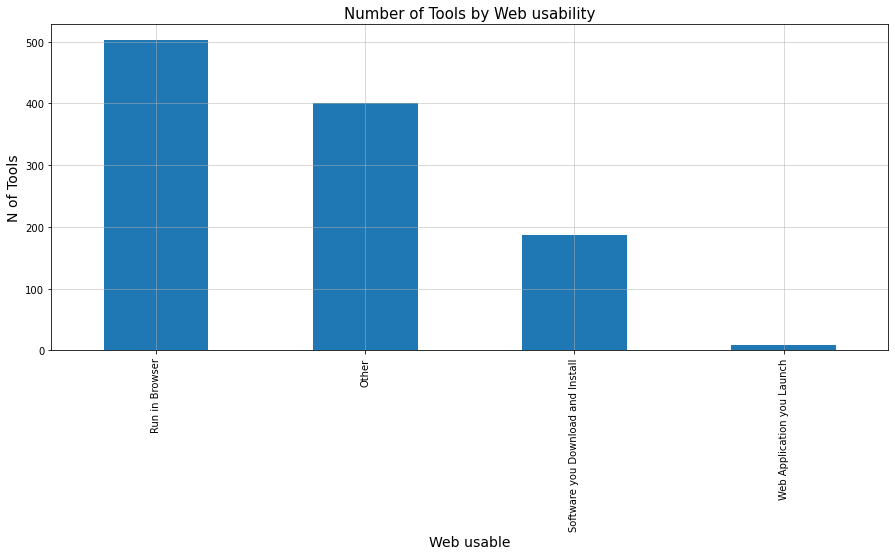

In [53]:
fig, ax = plt.subplots()
df_to_bp.plot(kind='bar', figsize=(15,6), x='webusable', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Tools by Web usability", fontsize=15)
ax.set_xlabel('Web usable', fontsize=14)
ax.set_ylabel('N of Tools', fontsize=14);
plt.show()

## ------